In [1]:
# load model (klu mau mencoba lagi model yg habis di test)
from keras.models import load_model
cnn_test = load_model('pengujian/train90_test10/epoch_10/model90_e10.h5')

In [8]:
# melakukan text processing yang sama dengan dataset sebelumnya
import numpy as np 
import pandas as pd
import re
import os

import keras
import keras.utils
from sklearn import preprocessing
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

from functools import partial

In [4]:
MAX_SEQUENCES_LENGTH = 50 # Maximum kata pada kalimat

In [6]:
# open dataset, save on dataframe
df = pd.read_csv("dataset500.csv",encoding="ISO-8859-1")

# membuka data slang (data yang akan dibenarkan)
with open('slang.txt') as file:
    slang_map = dict(map(str.strip, line.partition('\t')[::2])
    for line in file if line.strip())
    
df.head()

,text
0,warga palestina turun jalan medan juang bondon...
1,zionis israel laknat hancur hancur aamiin saudara
2,kaum pancasila sibuk suara benar palestina eh ...
3,wawancara provokator wawancara penghianat bang...
4,fix israel takut medsos mari gaung kabar gaza ...


In [9]:
# Pre-Processing dataset
# fungsi case folding dan menghapus RT dan CC
def casefoldingRemoveRt(text):
     # menghapus RT (reetwet)
    text = re.sub(r'^[RT]+', '', text) 
    # case folding (menjadi lower case)
    text = text.lower()
    # menghapus CC (carbon copy)
    text = re.sub(r'^[cc]+', '', text)
    return text

# fungsi untuk menghapus noise
def removeNoise(text): 
    # menghapus unicode
    text = re.sub(r'(\\u[0-9A-Fa-f]+)','', text)
    # menghapus emoticon
    text = re.sub(r'[^\x00-\x7f]','',text)
    # menghapus url
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',text) 
    # menghapus # (biasanya utk menandai topik tertentu)
    text = re.sub(r'#([^\s]+)', '', text) 
    # menghapus "@users"
    text = re.sub('@[^\s]+','',text)
    return text

# mengganti kata2 slang menjadi lebih baku
slang_words = sorted(slang_map, key=len, reverse=True) # longest first for regex
regex = re.compile(r"\b({})\b".format("|".join(map(re.escape, slang_words))))
replaceSlang = partial(regex.sub, lambda m: slang_map[m.group(1)])

def removePunctuation(text): 
    # menghapus integers/numbers
    text = ''.join([i for i in text if not i.isdigit()]) 
    # khusus untuk tanda baca ' (dirapatkan dengan text)
    text = re.sub("'",'',text)
    # menghapus punctuation (tanda baca)
    text = re.sub(r"[^A-Za-z]+"," ",text)
    # menghapus 1 karakter
    text = re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', text)
    # menghapus whitespace
    text = ' '.join(text.split())
    return text

In [10]:
df['text'] = df['text'].apply(lambda x: casefoldingRemoveRt(x))
df['text'] = df['text'].apply(lambda x: removeNoise(x))
df['text'] = df['text'].apply(lambda x: replaceSlang(x))
df['text'] = df['text'].apply(lambda x: removePunctuation(x))

In [11]:
df.head()

,text
0,warga palestina turun jalan medan juang bondon...
1,zionis israel laknat hancur hancur aamiin saudara
2,kaum pancasila sibuk suara benar palestina eh ...
3,wawancara provokator wawancara penghianat bang...
4,fix israel takut medsos mari gaung kabar gaza ...


In [12]:
#Tokenizing
from nltk.tokenize import word_tokenize 

In [13]:
# Stop Word
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

In [14]:
def stopWord(text):
    stop = stopword.remove(text)
    return stop

df['text'] = df['text'].apply(lambda x: stopWord(x))
df['text']

0      warga palestina turun jalan medan juang bondon...
1      zionis israel laknat hancur hancur aamiin saudara
2      kaum pancasila sibuk suara benar palestina eh ...
3      wawancara provokator wawancara penghianat bang...
4        fix israel takut medsos gaung kabar gaza banyak
                             ...                        
484    sumpah menang refugees afghanistan konflik ara...
485    kelompok profesional israel serang netflix tam...
486                              juang merdeka palestina
487    moga berkah maulid nabi tambah semangat juang ...
488                         juang bangsa palestina bebas
Name: text, Length: 489, dtype: object

In [15]:
# Stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [16]:
def stemming(text):
    stream = stemmer.stem(text)
    return stream

df['text'] = df['text'].apply(lambda x: stemming(x))
df['text']

0      warga palestina turun jalan medan juang bondon...
1      zionis israel laknat hancur hancur aamiin saudara
2      kaum pancasila sibuk suara benar palestina eh ...
3      wawancara provokator wawancara penghianat bang...
4        fix israel takut medsos gaung kabar gaza banyak
                             ...                        
484    sumpah menang refugees afghanistan konflik ara...
485    kelompok profesional israel serang netflix tam...
486                              juang merdeka palestina
487    moga berkah maulid nabi tambah semangat juang ...
488                         juang bangsa palestina bebas
Name: text, Length: 489, dtype: object

In [17]:
# delete missing value 
nan_value = float('NaN')
df.replace('', nan_value, inplace=True)
df.dropna(subset=['text'], inplace=True)

In [18]:
# delete data duplicate
df.drop_duplicates(subset='text', keep = 'first', inplace = True)

In [19]:
# save hasil clean
df.to_csv('dataset500_clean.csv', encoding='utf-8', index=False)

In [23]:
# memangil hasil tokenizer dari dataset sebelumnya
dfDataset = pd.read_csv("dataset500.csv",encoding="ISO-8859-1")
# Prepare to X as Feature
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dfDataset.text)
sequences = tokenizer.texts_to_sequences(dfDataset.text)

In [ ]:
# labels = ['0', '1', '2']

In [38]:
def cnn_predict(quest):
    puretext = tokenizer.texts_to_sequences(quest)
    text_pad = pad_sequences(puretext,maxlen=50,padding='post')
    predicted = cnn_test.predict(text_pad)
    predicted_category = predicted.argmax(axis=1)
    return predicted_category

In [41]:
labels = cnn_predict(df.text)

In [42]:
labels

array([2, 2, 1, 1, 1, 2, 2, 1, 0, 2, 2, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 2,
       1, 0, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2,
       1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 2, 1, 1, 2, 2, 1, 2, 1, 1,
       2, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 0, 1, 1, 2, 1, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2, 0, 2,
       0, 2, 1, 0, 0, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 1, 0, 1, 1, 2, 0, 2, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 0,
       1, 1, 1, 1, 2, 2, 0, 0, 2, 1, 2, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 0, 2, 2, 2, 1, 1, 1, 0, 2, 2,
       0, 1, 2, 1, 1, 0, 0, 2, 2, 0, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1,
       0, 2, 0, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1,
       1, 2, 0, 0, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2,

In [43]:
# memasukan hasil labels tersebut ke dalam dataframe
df['label'] = labels

In [44]:
df.head()

,text,label
0,warga palestina turun jalan medan juang bondon...,2
1,zionis israel laknat hancur hancur aamiin saudara,2
2,kaum pancasila sibuk suara benar palestina eh ...,1
3,wawancara provokator wawancara penghianat bang...,1
4,fix israel takut medsos gaung kabar gaza banyak,1


1    270
2    138
0     81
Name: label, dtype: int64


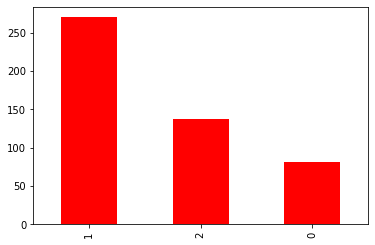

In [46]:
# menghitung hasil sentiment terhadap data baru
labels_count = df.label.value_counts()
labels_count.plot(kind="bar", x='Label', y='Jumlah', color='red')
print(df.label.value_counts())